# Calclulate the scale (factor) of the universe over cosmological time
for the Λcdm model, with variable parameters, and other toy models

## Initialization Cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time as tm
from scipy.optimize import curve_fit
from tqdm import tqdm
#%matplotlib widget

def tic():
    # Initialize clock for timing
    global startTime_for_tictoc
    startTime_for_tictoc = tm.perf_counter_ns()
    print (f"Timer set!")
    return

def toc():
    # report time since last tic() initialization in seconds
    global most_recent_toc
    if 'startTime_for_tictoc' in globals():
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(tm.perf_counter_ns() - startTime_for_tictoc)*1e-9:.3f} seconds.")
    else:
        print ("Toc Error: start time not set")
    return

def tocms():
    # report time since last tic() initialization in ms
    global most_recent_toc
    if 'startTime_for_tictoc' in globals():
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(tm.perf_counter_ns() - startTime_for_tictoc)*1e-6:.3f} milliseconds.")
    else:
        print ("Toc Error: start time not set")
    return
global most_recent_toc
most_recent_toc = -666

In [2]:
# a function to smoothly to transition between piecewise pieces
def smoothstep(x,center, width):
    #fraction = 1/(np.exp((x-center)/width)+1)
    fraction = np.arctan(-(x-center)/width)/np.pi+0.5
    return fraction

def Λcdmslope(H_0,a,Or,Om,Ok,OΛ,prevslope):
    if a<0: slope = 0
    else:
        #magnitude of slope (squared)
        radical = Or*np.power(a,-2)+Om*np.power(a,-1)+Ok+OΛ*np.power(a,2)
        # sign of slope from acceleration
        if (2 > 1): sign = 1
        else: sign = -1
        
        if (radical < 0): slope = -H_0*np.sqrt(-radical)
        elif (prevslope < 0): slope = -H_0*np.sqrt(radical)
        else: slope = H_0*np.sqrt(radical)
    return slope

def Λcdmaccel(a,G,ρ0r,ρ0m,ρ0Λ):
    if a<0: accel = 0
    else: accel = -4*np.pi*G/3*(ρ0m*a**(-2)+2*ρ0r*a**(-3)-2*ρ0Λ*a)

    return accel

HtokmMpc = 3.09e10/31556926

## Λcdm model

In [3]:
### User Inputs
tmin = -15 # time range to plot in Gy
tmax = 1
c = 1 # speed of light
G = 1 # gravitational constant
t_step = 1e4 # years between integration steps; caution: values below ~1000 may cause memory issues

H_0 = 67.6/HtokmMpc # conversion of 67.6 (km / s / Mpc) to 0.069 (1/Gy)

# Currently observed mass-energy contributions
    # Ω's do not need to be normalized on input
Ωrn = 0.00008*0.99  # 0.00008  ; amount of "radiation-like" mass-energy density
Ωmn = 0.286*0.99    # 0.286    ; amount of "matter-like" mass-energy density
Ωkn = 0.01          # 0 ± 0.02 ; amount of "intrinsic curvature" mass-energy density
ΩΛn = 0.714*0.99    # 0.714    ; amount of "constant" mass-energy density

Renormalized Λcdm parameters: 
Ω_r: 0.008%, Ω_m: 28.312%, Ω_Λ: 70.680%, Ω_tot: 99.000%
Effective spatial radius of curvature (at t_0): -20983 GLy

Minimum scale factor calculated: 4.43e-03, at t=-14.150 Gy


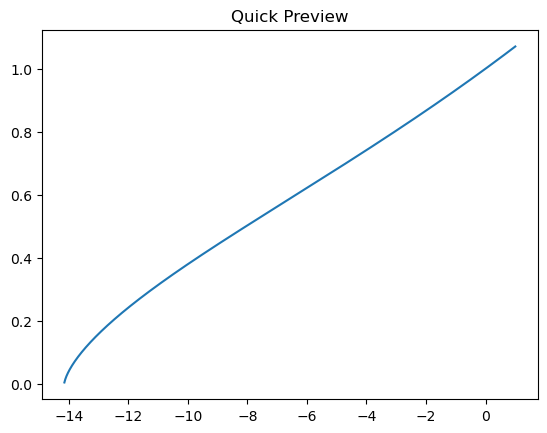

In [4]:
#### Generate quick preview of selected time range before high-res integration

# normalized energy density contributions
Ωr = Ωrn/(Ωrn+Ωmn+Ωkn+ΩΛn)
Ωm = Ωmn/(Ωrn+Ωmn+Ωkn+ΩΛn)
Ωk = Ωkn/(Ωrn+Ωmn+Ωkn+ΩΛn)
ΩΛ = ΩΛn/(Ωrn+Ωmn+Ωkn+ΩΛn)
print(f"Renormalized Λcdm parameters: \nΩ_r: {100*Ωr:0.3f}%, Ω_m: {100*Ωm:0.3f}%, Ω_Λ: {100*ΩΛ:0.3f}%, Ω_tot: {100*(Ωm+Ωr+ΩΛ):0.3f}%")

ρ_0crit = 3*H_0**2/(8*np.pi*G)
ρ_0r = ρ_0crit*Ωr
ρ_0m = ρ_0crit*Ωm
ρ_0k = ρ_0crit*Ωk
ρ_0Λ = ρ_0crit*ΩΛ

print(f"Effective spatial radius of curvature (at t_0): {-1/((ρ_0k/ρ_0crit)*H_0**2):.0f} GLy")
times = np.linspace(tmin,tmax,round(tmax-tmin)*100+1)
times_0 = np.argmin(abs(times))
a = [1.]*len(times)
dadt = H_0
accel = Λcdmaccel(a[0],G,ρ_0r,ρ_0m,ρ_0Λ)
dt = times[1]-times[0]
for i in range(0,times_0):  # integrate backwards in time  
    newa = a[times_0-i] - dadt*dt - 0.5*dt**2*accel
    
    if newa > 0: 
        a[times_0-1-i] = newa
        newaccel = Λcdmaccel(newa,G,ρ_0r,ρ_0m,ρ_0Λ) # calculate acceleration at new time step
        dadt = dadt - 0.5*accel*dt-0.5*newaccel*dt # update velocity from accel and new accel
        accel = newaccel
    else:
        a[times_0-1-i] = 0
        continue

accel = Λcdmaccel(a[times_0],G,ρ_0r,ρ_0m,ρ_0Λ)
dadt = H_0
for i in range(1,len(times)-times_0): # integrate forwards in time
    newa = a[times_0-1+i] + dadt*dt + 0.5*dt**2*accel
    a[times_0+i] = newa
    
    newaccel = Λcdmaccel(newa,G,ρ_0r,ρ_0m,ρ_0Λ)
    dadt = dadt + 0.5*accel*dt+0.5*newaccel*dt
    accel = newaccel

a = np.where(np.array(a)>0,np.array(a),float("nan"))
print(f"\nMinimum scale factor calculated: {np.nanmin(a):.2e}, at t={times[np.nanargmin(abs(a-np.nanmin(a)))]:.3f} Gy")
plt.close()
plt.title("Quick Preview")
plt.plot(times,a)
plt.show()

In [5]:
#### Perform Integration
times = np.linspace(times[np.nanargmin(abs(a-np.nanmin(a)))]-(times[1]-times[0]),tmax,round((tmax-times[np.nanargmin(abs(a-np.nanmin(a)))])*1e9/t_step)+1)
dt = times[1]-times[0]
print(f"Actual integration step size used: {dt*1e6:.3f}"," ky")
times_0 = np.argmin(abs(times))

a = [1.]*len(times)
r = [-666.0]*len(times)
dadt = [H_0]*len(times)
accel = Λcdmaccel(a[0],G,ρ_0r,ρ_0m,ρ_0Λ) # acceleration of a at t=0
q=[-accel/H_0**2]*len(times)
tic()

pbar = tqdm(total=len(times),unit_scale=1,ascii=True,leave=False) #
nupdates = max(10,round(len(times)/1e4-30))
for i in range(0,times_0):  # integrate backwards in time  
    if i%(5e4)==0: pbar.set_description(desc=f"Calculating a({times[times_0-i]:0.1f} Gy)...")

    newa = a[times_0-i] - dadt[times_0-i]*dt - 0.5*dt**2*accel
    
    a[times_0-1-i] = newa if newa>0 else float("nan")
    
    if newa < 0: 
        dadt[times_0-1-i] = float("nan")
        q[times_0-1-i] = float("nan")
        r[times_0-1-i] = float("nan")
        continue
    if i==0: r[times_0-1-i] =              c*0.5*(1/a[times_0-i-1]+1/a[times_0-i])*dt
    else:    r[times_0-1-i] = r[times_0-i]+c*0.5*(1/a[times_0-i-1]+1/a[times_0-i])*dt
    newaccel = Λcdmaccel(newa,G,ρ_0r,ρ_0m,ρ_0Λ) # calculate acceleration at new time step

    newdadt = dadt[times_0-i] - 0.5*accel*dt-0.5*newaccel*dt # update velocity from accel and new accel
    dadt[times_0-1-i] = newdadt
    q[times_0-1-i] = -newaccel*newa/newdadt**2
    accel = newaccel
    pbar.update()
accel = Λcdmaccel(a[times_0],G,ρ_0r,ρ_0m,ρ_0Λ) # acceleration of a at t=0
r[times_0] = r[times_0-1]-c*0.5*(1/a[times_0-1]+1/a[times_0])*dt
for i in range(1,len(times)-times_0): # integrate forwards in time
    if (i+times_0)%(5e4)==0: pbar.set_description(desc=f"Calculating a({times[times_0+i]:0.1f} Gy)...")
    newa = a[times_0-1+i] + dadt[times_0-1+i]*dt + 0.5*dt**2*accel
    a[times_0+i] = newa
    r[times_0+i] = r[times_0+i-1]-c*0.5*(1/a[times_0-1+i]+1/a[times_0+i])*dt
    
    newaccel = Λcdmaccel(newa,G,ρ_0r,ρ_0m,ρ_0Λ)

    newdadt = dadt[times_0-1+i] + 0.5*accel*dt+0.5*newaccel*dt
    dadt[times_0+i] = newdadt
    q[times_0+i] = -newaccel*newa/newdadt**2
    accel = newaccel
    pbar.update()
pbar.close()
toc()
a = np.array(a)
dadt = np.array(dadt)
r =np.array(r)

H = dadt/a
z = 1/a - 1
Hobs = z/r
if (Hobs[times_0]!=Hobs[times_0]): Hobs[times_0] = 0.5*(Hobs[times_0-1]+Hobs[times_0+1])

# rho's
rho_crit = 3*H**2/(8*np.pi*G)
rho_r = ρ_0r*a**-4
rho_m = ρ_0m*a**-3
rho_Λ = ρ_0Λ
rho_k = rho_crit-rho_r-rho_m-rho_Λ
rho_tot = rho_r + rho_m + rho_Λ

print(f"\nMinimum scale factor calculated: {np.nanmin(a):.2e}, at t = {times[np.nanargmin(abs(a-np.nanmin(a)))]:.1f} Gy")

Actual integration step size used: 10.007  ky
Timer set!


Elapsed time is 17.328 seconds.

Minimum scale factor calculated: 4.59e-05, at t = -14.1 Gy


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


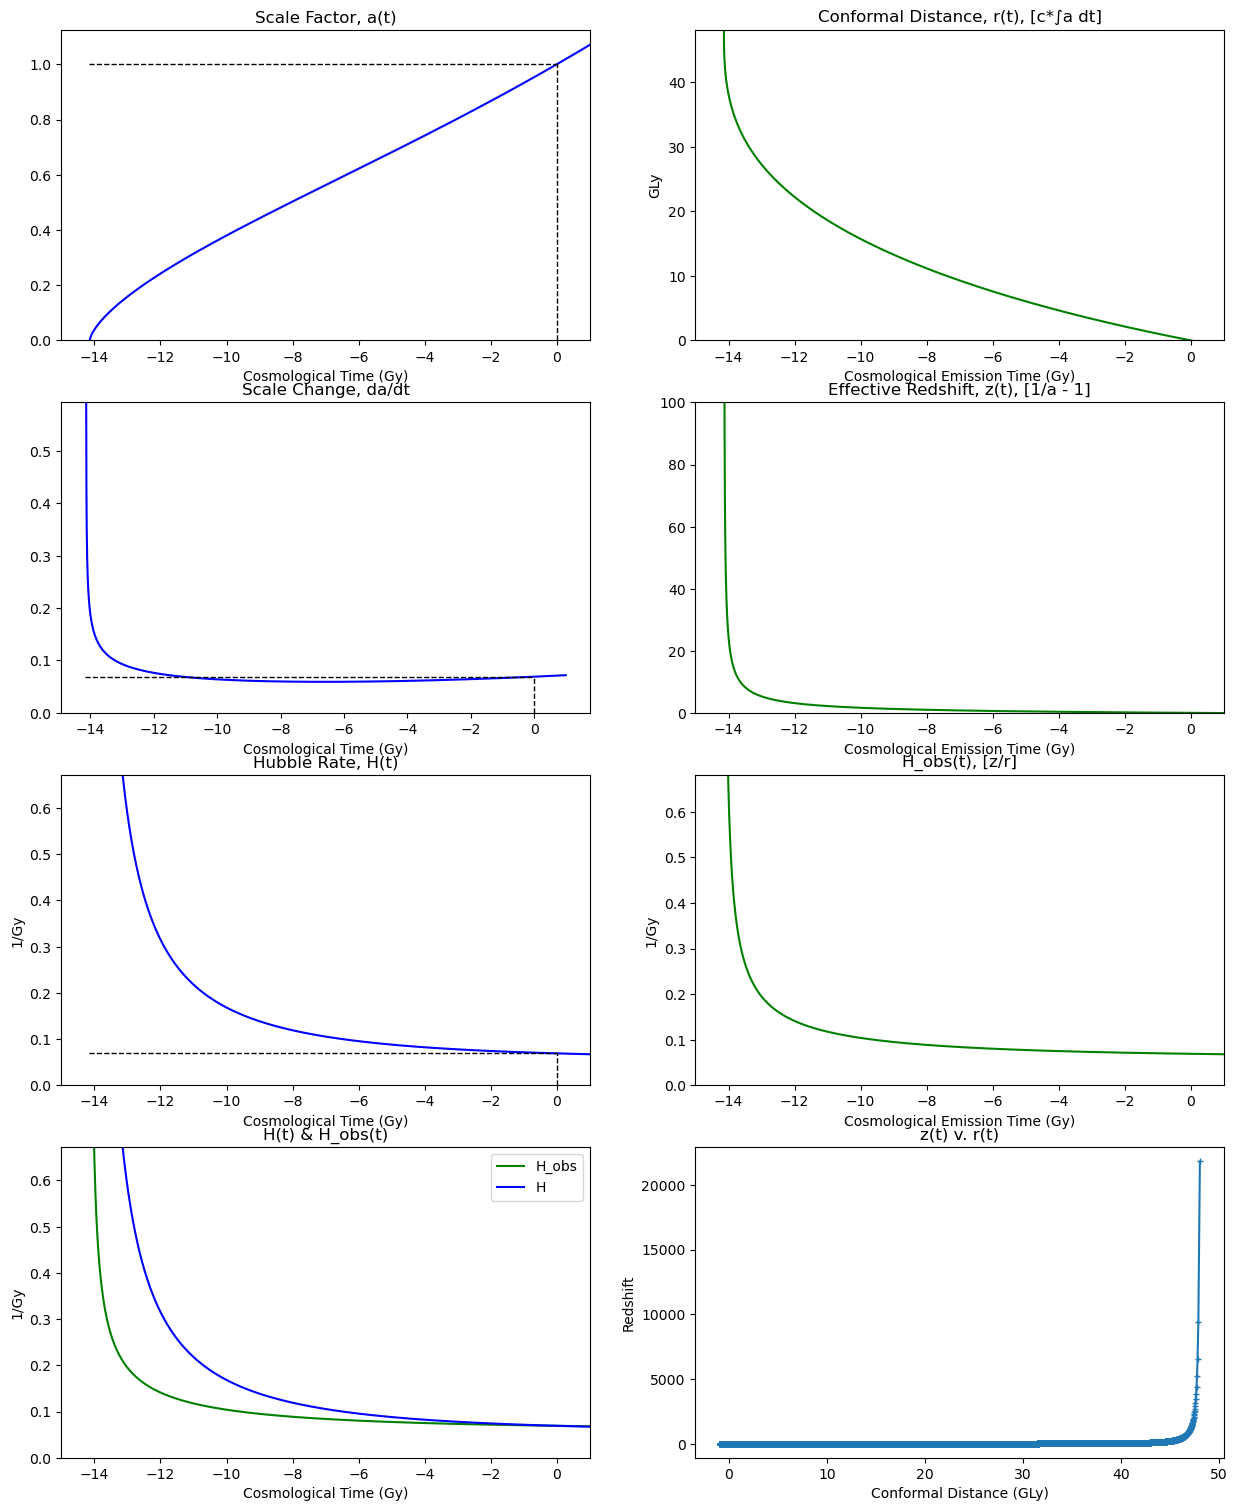

In [6]:
####  Graph Results
logify = False
#tmin = -8 #ts[np.argmax(1/a)]-1.2
#tmax = 1 # 16.2

plt.close()
width = 15
fig,ax = plt.subplots(4,2,figsize=(width,2*width*2/(1+np.sqrt(5))))
ax[0,0].set_title("Scale Factor, a(t)")
ax[0,0].set_xlabel("Cosmological Time (Gy)")
ax[0,0].plot(times,a,color="blue")
ax[0,0].plot([times[0],0],[1,1],"--",linewidth=1,color="black")
ax[0,0].plot([0,0],[0,1],"--",linewidth=1,color="black")
ax[0,0].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),tmax)
ax[0,0].set_ylim(0,
                 1.05*np.nanmax(a[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))])) #
if (logify): 
    ax[0,0].set_ylim(np.nanmin(a),1.05*np.nanmax(a))
    ax[0,0].set_yscale("log")

    
ax[1,0].set_title("Scale Change, da/dt")
ax[1,0].set_xlabel("Cosmological Time (Gy)")
ax[1,0].plot(times,dadt,color="blue")
ax[1,0].plot([times[0],0],[dadt[times_0],dadt[times_0]],"--",linewidth=1,color="black")
ax[1,0].plot([0,0],[0,dadt[times_0]],"--",linewidth=1,color="black")
#ax[1,0].set_xlim(tmin,tmax)
if np.nanmin(dadt[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]) == 0.:
    ax[1,0].set_ylim(0, 1.1*np.nanmax(dadt[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]))
else:
    ax[1,0].set_ylim(0, min(1.1*np.nanmax(dadt[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),
                        10*np.nanmin(dadt[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]))  )
if (logify): 
    if np.nanmin(dadt) == 0.: ax[1,0].set_ylim(np.nanmax(dadt)/100,1.05*np.nanmax(dadt))
    else: ax[1,0].set_ylim(np.nanmin(dadt),1.05*np.nanmax(dadt))
    ax[1,0].set_yscale("log")

    
ax[2,0].set_title("Hubble Rate, H(t)")
ax[2,0].set_xlabel("Cosmological Time (Gy)")
ax[2,0].set_ylabel("1/Gy")
ax[2,0].plot(times,H,color="blue")
ax[2,0].plot([times[0],0],[H[times_0],H[times_0]],"--",linewidth=1,color="black")
ax[2,0].plot([0,0],[0,H[times_0]],"--",linewidth=1,color="black")
ax[2,0].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]) == 0.:
    ax[2,0].set_ylim(0,1.1*np.nanmax(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]))
else: 
    ax[2,0].set_ylim(0, min(1.1*np.nanmax(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),
                            10*np.nanmin(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))])) )
#if (logify): ax[2,0].set_yscale("log")

ax[0,1].set_title("Conformal Distance, r(t), [c*∫a dt]")
ax[0,1].set_xlabel("Cosmological Emission Time (Gy)")
ax[0,1].set_ylabel("GLy")
ax[0,1].plot(times,r,color="green")

#ax[0,1].set_xlim(-0.1,0.1)
ax[0,1].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),1)
ax[0,1].set_ylim(0,
                 min(np.nanmax(r[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),100))
if (logify): 
    ax[0,1].set_ylim(np.nanmin(abs(r)),np.nanmax(r))
    ax[0,1].set_yscale("log")
#ax[0,1].set_ylim(0,2)

ax[1,1].set_title("Effective Redshift, z(t), [1/a - 1]")
ax[1,1].set_xlabel("Cosmological Emission Time (Gy)")
ax[1,1].plot(times,z,color="green")
#ax[1,1].set_xlim(-0.1,0.1)
ax[1,1].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),1)
ax[1,1].set_ylim(0,
                 min(1.05*np.nanmax(z[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),100))
#ax[1,1].set_ylim(-0.1,1.1)
if (logify): 
    if z[times_0-1] == 0.: ax[1,1].set_ylim(np.nanmax(z)/100,1.05*np.nanmax(z))
    else: ax[1,1].set_ylim(z[times_0-1],1.05*np.nanmax(z))
    ax[1,1].set_yscale("log")
#ax[1,1].set_ylim(-0.1,0.1)

ax[2,1].set_title("H_obs(t), [z/r]")
ax[2,1].set_xlabel("Cosmological Emission Time (Gy)")
ax[2,1].set_ylabel("1/Gy")
ax[2,1].plot(times,Hobs,color="green")
#if (logify): ax[2,1].set_yscale("log")
#ax[2,1].set_xlim(-0.1,0.1)
ax[2,1].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),1)
if np.nanmin(Hobs[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]) == 0.:
    ax[2,1].set_ylim(0,1.1*np.nanmax(Hobs[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]))
else: 
    ax[2,1].set_ylim(0, min(1.1*np.nanmax(Hobs[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),
                            10*np.nanmin(abs(Hobs[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))])))  )

ax[3,0].set_title("H(t) & H_obs(t)")
ax[3,0].set_xlabel("Cosmological Time (Gy)")
ax[3,0].set_ylabel("1/Gy")
ax[3,0].plot(times,Hobs,label="H_obs",color="green")
ax[3,0].plot(times,H,label="H",color="blue")
#if (logify): ax[3,0].set_yscale("log")
ax[3,0].legend()
ax[3,0].set_xlim(max(times[np.nanargmax(1/a[0:times_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]) == 0.:
    ax[3,0].set_ylim(0,1.1*np.nanmax(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]))
else: 
    ax[3,0].set_ylim(0, min(1.1*np.nanmax(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))]),
                            10*np.nanmin(H[np.argmin(abs(times-tmin)):np.argmin(abs(times-tmax))])) )
#ax[3,0].set_ylim(60,100)

ax[3,1].set_title("z(t) v. r(t)")
ax[3,1].set_xlabel("Conformal Distance (GLy)")
ax[3,1].set_ylabel("Redshift")
ax[3,1].plot(r,z,markersize=5,marker="+")
#ax[3,1].set_xscale("log")
#ax[3,1].set_yscale("log")
#ax[3,1].set_xlim(0,r[np.nanargmin(abs(z-1100))])
#ax[3,1].set_xlim(0,np.nanmax(r))
#ax[3,1].set_ylim(0,20)

plt.show()

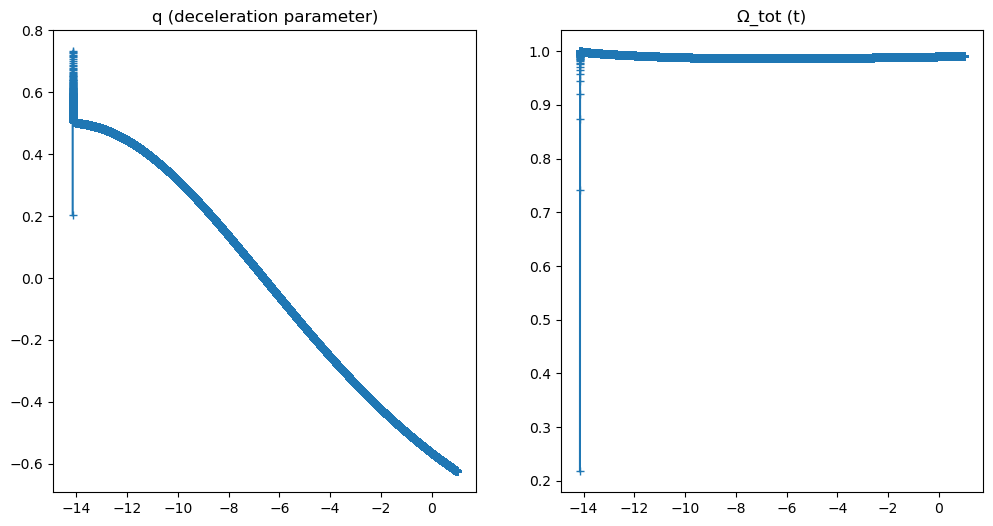

In [9]:
#### Graph deceleration and Omega history

plt.close()
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_title("q (deceleration parameter)")
ax[0].plot(times,q,marker="+")
#ax[0].legend()
#ax[0].set_xlim(-14.14,-14.138)
#ax[0].set_ylim(0.5,1)

ax[1].plot(times,rho_tot/rho_crit,marker="+")
ax[1].set_title("Ω_tot (t)")
#ax[1].legend()
#ax[1].set_xlim(-14.14,-14.138)
#ax[1].set_ylim(0.9,1.1)
#ax[1].set_yscale("log")

plt.show()

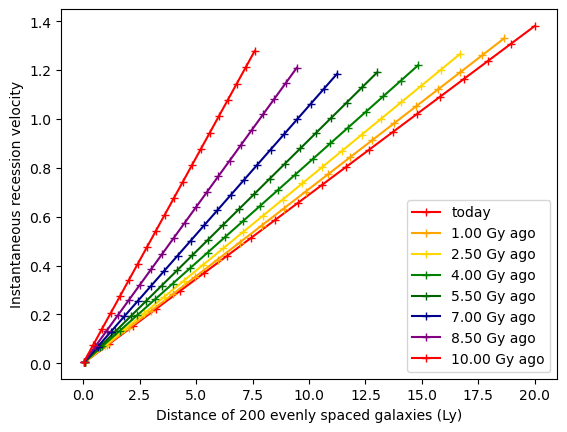

In [10]:
#### Gaia's perspective: Gaia looks into the sky, and needs not wait for photons to arrive; 
   # she instantly knows the conformal distances and relative velocities of each galaxy at any instant of cosmological time

# start with 20 galaxies which happen to be evenly spaced and match Hubble's Law (v ~ H*d) at t=0
# What does Gaia see as their (v vs. d) relationship over cosmological time?

# d(t) = d0 * a(t)
# v(t) = d0 * da/dt
d0 = np.linspace(0.1,20,20)*a[times_0]
v0 = d0*dadt[times_0]

t1 = -1
d1 = d0*a[np.argmin(abs(times-t1))]
v1 = d0*dadt[np.argmin(abs(times-t1))]

t2 = -2.5
d2 = d0*a[np.argmin(abs(times-t2))]
v2 = d0*dadt[np.argmin(abs(times-t2))]

t3 = -4
d3 = d0*a[np.argmin(abs(times-t3))]
v3 = d0*dadt[np.argmin(abs(times-t3))]

t4 = -5.5
d4 = d0*a[np.argmin(abs(times-t4))]
v4 = d0*dadt[np.argmin(abs(times-t4))]

t5 = -7
d5 = d0*a[np.argmin(abs(times-t5))]
v5 = d0*dadt[np.argmin(abs(times-t5))]

t6 = -8.5
d6 = d0*a[np.argmin(abs(times-t6))]
v6 = d0*dadt[np.argmin(abs(times-t6))]

t7 = -10
d7 = d0*a[np.argmin(abs(times-t7))]
v7 = d0*dadt[np.argmin(abs(times-t7))]
# position at any time is dn_0 * a(t)
# velocity at any time is dn_0 * da/dt(t)

# the graph above shows that for a single galaxy over time, its v/r value will change
# Hubble looked at single time, how v/r changes with initial distance

# this is assuming that you can **INSTANTANEOUSLY*** determine the current velocity and distance
# ANY history a(t) starting with evenly-spaced galaxies will remain evenly spaced
#  geometry analogy: evenly spaced points on the x-axis are always evenly spaced as you "stretch" the x axis as any function of time
#  !!!!!  this can tell you nothing of a(t)  !!!!!

#  .... fortunately, we do not instantly know the recession velocity right now.  We only know the (relative) scale factor at the time of emission
plt.close()
plt.xlabel("Distance of 200 evenly spaced galaxies (Ly)")
plt.ylabel("Instantaneous recession velocity")
plt.plot(d0,v0,label="today",marker="+",color="red")
plt.plot(d1,v1,label=f"{-times[np.argmin(abs(times-t1))]:0.2f} Gy ago",marker="+",color="orange")
plt.plot(d2,v2,label=f"{-times[np.argmin(abs(times-t2))]:0.2f} Gy ago",marker="+",color="gold")
plt.plot(d3,v3,label=f"{-times[np.argmin(abs(times-t3))]:0.2f} Gy ago",marker="+",color="green")
plt.plot(d4,v4,label=f"{-times[np.argmin(abs(times-t4))]:0.2f} Gy ago",marker="+",color="darkgreen")
plt.plot(d5,v5,label=f"{-times[np.argmin(abs(times-t5))]:0.2f} Gy ago",marker="+",color="darkblue")
plt.plot(d6,v6,label=f"{-times[np.argmin(abs(times-t6))]:0.2f} Gy ago",marker="+",color="purple")
plt.plot(d7,v7,label=f"{-times[np.argmin(abs(times-t7))]:0.2f} Gy ago",marker="+",color="red")
plt.legend()
plt.show()

## Great Breath Model

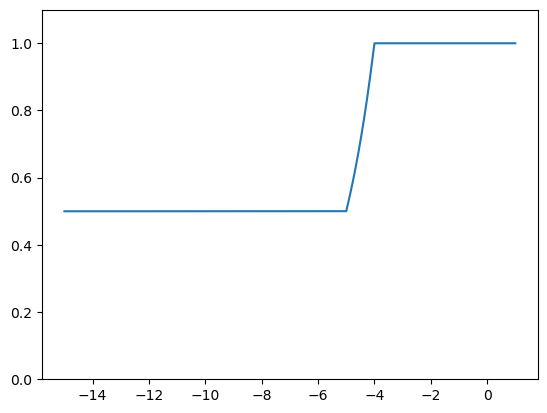


Minimum scale factor calculated: 5.00e-01, at t = -15.0 Gy


In [11]:
#### Great Breath Model: a simplified expansion history to examine difference between H (a'/a) and H_obs (z/r)
   # The universe is static for 10 Gy, then suddenly, the universe rapidly expands (over 1 Gy) to twice its size, like a balloon filled with one strong, deep breath, and is then static once more
   # All light emitted before the Great Breath will be affected by the expansion, but what is the relationship we observe?
tmin = -15
tmax = 1
times = np.linspace(tmin,tmax,100001)
dt = times[1]-times[0]
times_0 = np.argmin(abs(times))
c = 1 # speed of light
G = 1 # gravitational constant

ScaleFactor = np.where(times<-5,0.5,
                np.where(times<-4,0.5*times+3,
                1))
tau = 1/np.log(2)
A = 1/np.exp(-4/tau)
ScaleFactor = np.where(times<-5,0.5,
                np.where(times<-4,A*np.exp(times/tau),
                1))
plt.close()
plt.plot(times,ScaleFactor)

plt.ylim(0,1.1*np.nanmax(ScaleFactor))
plt.show()
print(f"\nMinimum scale factor calculated: {np.nanmin(ScaleFactor):.2e}, at t = {times[np.nanargmin(abs(ScaleFactor-np.nanmin(ScaleFactor)))]:.1f} Gy")

In [12]:
tic()
# cosmological time
ts = times[1:]

# a
a = ScaleFactor[1:]
t_0 = times_0 - 1

# a-dot
dadt = (ScaleFactor[1:]-ScaleFactor[:-1])/dt

# H(t)
H = dadt/a

# z
z = 1/a - 1

# r 
r = [-666.0]*len(ts) # r(a=1) = 0 ..... just make this r[times20-1]

pbar = tqdm(total=len(a),unit_scale=1,ascii=True,leave=False) #

for i in range(0,t_0):
    if i==0: 
        r[t_0-1-i] = c*0.5*(1/a[t_0-i-1]+1/a[t_0-i])*dt
    else: r[t_0-1-i] = r[t_0-i]    +c*0.5*(1/a[t_0-i-1]+1/a[t_0-i])*dt
    pbar.update()
r[t_0] = r[t_0-1]-c*0.5*(1/a[t_0-1]+1/a[t_0])*dt
for i in range(1,len(a)-t_0):
    r[t_0+i] = r[t_0+i-1]-c*0.5*(1/a[t_0-1+i]+1/a[t_0+i])*dt
    pbar.update()
    # a signal emits at (cosmological) time t... it then travels to earth to arrive at t=0
    # the total distance traveled is the luminous distance, and it is c*tbar where tbar is the conformal time
    # in order to arrive today from a more distant galaxy, it needs to have emitted at an earlier time -- those signals will carry more expansion history
pbar.close()

# H_observed
r = np.array(r)
Hobs = z/r

# rho's
# q -- deceleration parameter
d2adt2 = (dadt[1:]-dadt[:-1])/dt
d2adt2[t_0] = d2adt2[t_0-1]
qa = a[1:]
qdadt = dadt[1:]
qdadt = np.where(qdadt!=0.,qdadt,float("nan"))
q = -d2adt2*qa/qdadt**2
#np.where(abs(qdadt)>0.0001,-d2adt2*qa/qdadt/qdadt,float("nan"))  -d2adt2*qa/qdadt/qdadt
toc()

Timer set!


Elapsed time is 0.412 seconds.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


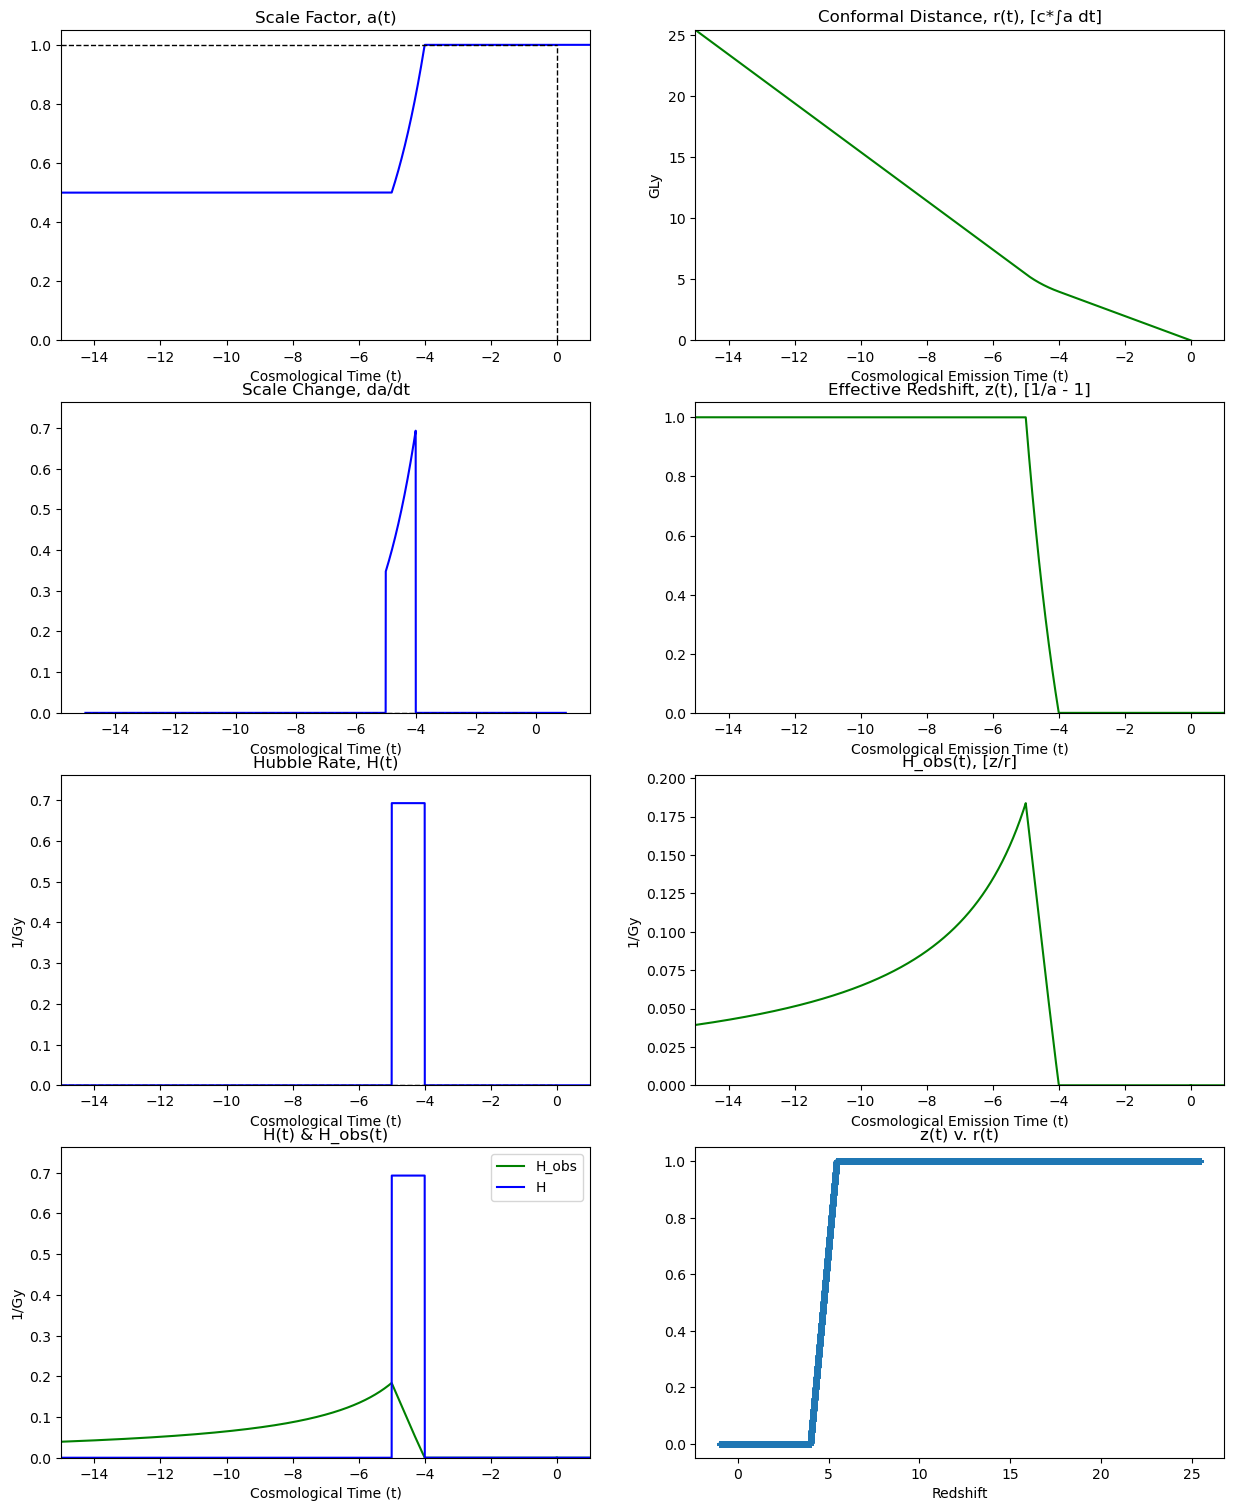

In [13]:
logify = False
#tmin = -8 #ts[np.argmax(1/a)]-1.2
#tmax = 1 # 16.2

HtokmMpc = 3.09e10/31556926
plt.close()
width = 15
fig,ax = plt.subplots(4,2,figsize=(width,2*width*2/(1+np.sqrt(5))))
ax[0,0].set_title("Scale Factor, a(t)")
ax[0,0].set_xlabel("Cosmological Time (t)")
ax[0,0].plot(ts,a,color="blue")
ax[0,0].plot([ts[0],0],[1,1],"--",linewidth=1,color="black")
ax[0,0].plot([0,0],[0,1],"--",linewidth=1,color="black")
#ax[0,0].plot(ts,[0]*len(ts),"--",linewidth=2,color="black")
ax[0,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),tmax)
ax[0,0].set_ylim(0,
                 1.05*np.nanmax(a[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) #
if (logify): 
    ax[0,0].set_ylim(np.nanmin(a),1.05*np.nanmax(a))
    ax[0,0].set_yscale("log")

    
ax[1,0].set_title("Scale Change, da/dt")
ax[1,0].set_xlabel("Cosmological Time (t)")
ax[1,0].plot(ts,dadt,color="blue")
ax[1,0].plot([ts[0],0],[dadt[t_0],dadt[t_0]],"--",linewidth=1,color="black")
ax[1,0].plot([0,0],[0,dadt[t_0]],"--",linewidth=1,color="black")
#ax[1,0].set_xlim(tmin,tmax)
if np.nanmin(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[1,0].set_ylim(0, 1.1*np.nanmax(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else:
    ax[1,0].set_ylim(0, min(1.1*np.nanmax(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                        10*np.nanmin(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))  )
if (logify): 
    if np.nanmin(dadt) == 0.: ax[1,0].set_ylim(np.nanmax(dadt)/100,1.05*np.nanmax(dadt))
    else: ax[1,0].set_ylim(np.nanmin(dadt),1.05*np.nanmax(dadt))
    ax[1,0].set_yscale("log")

    
ax[2,0].set_title("Hubble Rate, H(t)")
ax[2,0].set_xlabel("Cosmological Time (t)")
ax[2,0].set_ylabel("1/Gy")
ax[2,0].plot(ts,H,color="blue")
ax[2,0].plot([ts[0],0],[H[t_0],H[t_0]],"--",linewidth=1,color="black")
ax[2,0].plot([0,0],[0,H[t_0]],"--",linewidth=1,color="black")
ax[2,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[2,0].set_ylim(0,1.1*np.nanmax(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[2,0].set_ylim(0, min(1.1*np.nanmax(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) )
#if (logify): ax[2,0].set_yscale("log")

ax[0,1].set_title("Conformal Distance, r(t), [c*∫a dt]")
ax[0,1].set_xlabel("Cosmological Emission Time (t)")
ax[0,1].set_ylabel("GLy")
ax[0,1].plot(ts,r,color="green")

#ax[0,1].set_xlim(-0.1,0.1)
ax[0,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
ax[0,1].set_ylim(0,
                 min(np.nanmax(r[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),100))
if (logify): 
    ax[0,1].set_ylim(np.nanmin(abs(r)),np.nanmax(r))
    ax[0,1].set_yscale("log")
#ax[0,1].set_ylim(0,2)

ax[1,1].set_title("Effective Redshift, z(t), [1/a - 1]")
ax[1,1].set_xlabel("Cosmological Emission Time (t)")
ax[1,1].plot(ts,z,color="green")
#ax[1,1].set_xlim(-0.1,0.1)
ax[1,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
ax[1,1].set_ylim(0,
                 min(1.05*np.nanmax(z[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),100))
#ax[1,1].set_ylim(-0.1,1.1)
if (logify): 
    if z[t_0-1] == 0.: ax[1,1].set_ylim(np.nanmax(z)/100,1.05*np.nanmax(z))
    else: ax[1,1].set_ylim(z[t_0-1],1.05*np.nanmax(z))
    ax[1,1].set_yscale("log")
#ax[1,1].set_ylim(-0.1,0.1)

ax[2,1].set_title("H_obs(t), [z/r]")
ax[2,1].set_xlabel("Cosmological Emission Time (t)")
ax[2,1].set_ylabel("1/Gy")
ax[2,1].plot(ts,Hobs,color="green")
#if (logify): ax[2,1].set_yscale("log")
#ax[2,1].set_xlim(-0.1,0.1)
ax[2,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[2,1].set_ylim(0,1.1*np.nanmax(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[2,1].set_ylim(0, min(1.1*np.nanmax(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*np.nanmin(abs(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])))  )

ax[3,0].set_title("H(t) & H_obs(t)")
ax[3,0].set_xlabel("Cosmological Time (t)")
ax[3,0].set_ylabel("1/Gy")
ax[3,0].plot(ts,Hobs,label="H_obs",color="green")
ax[3,0].plot(ts,H,label="H",color="blue")
#if (logify): ax[3,0].set_yscale("log")
ax[3,0].legend()
ax[3,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[3,0].set_ylim(0,1.1*np.nanmax(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[3,0].set_ylim(0, min(1.1*np.nanmax(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) )
#ax[3,0].set_ylim(60,100)

ax[3,1].set_title("z(t) v. r(t)")
ax[3,1].set_xlabel("Conformal Distance (GLy)")
ax[3,1].set_xlabel("Redshift")
ax[3,1].plot(r,z,markersize=5,marker="+")
#ax[3,1].set_xscale("log")
#ax[3,1].set_yscale("log")
#ax[3,1].set_xlim(0,r[np.nanargmin(abs(z-1100))])
#ax[3,1].set_xlim(0,np.nanmax(r))
#ax[3,1].set_ylim(0,20)

plt.show()

## Linear-to-Exponential Switch

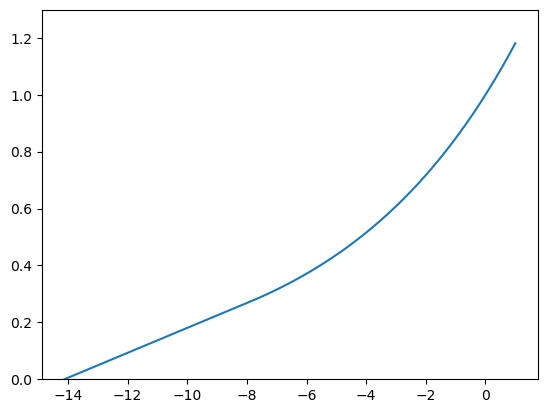


Minimum scale factor calculated: 1.28e-07, at t = -14.1 Gy


In [16]:
#### H_obs diverges from H as the expansion stops being exponential
tmin = -15
tmax = 1
times = np.linspace(tmin,tmax,1000001)
dt = times[1]-times[0]
times_0 = np.argmin(abs(times))
c = 1 # speed of light
G = 1 # gravitational constant

tswitch = -8
offs = 7
A = 0.5*tswitch+offs
tau = 2*A
mywidth = 1
'''
ScaleFactor = np.where(times<-15,0,
                np.where(times<tswitch,0.5*times+offs,
                A*np.exp((times-tswitch)/tau)))'''

ScaleFactor = smoothstep(times,tswitch,mywidth)*(0.5*times+offs)+(1-smoothstep(times,tswitch,mywidth))*A*np.exp((times-tswitch)/tau)
ScaleFactor = ScaleFactor/ScaleFactor[times_0]
ScaleFactor = np.where(np.array(ScaleFactor)>0,np.array(ScaleFactor),float("nan"))

plt.close()
plt.plot(times,ScaleFactor)
#plt.plot(times,smoothstep(times,tswitch,mywidth))
plt.ylim(0,1.1*np.nanmax(ScaleFactor))
plt.show()
print(f"\nMinimum scale factor calculated: {np.nanmin(ScaleFactor):.2e}, at t = {times[np.nanargmin(abs(a-np.nanmin(ScaleFactor)))]:.1f} Gy")

In [17]:
tic()
# cosmological time
ts = times[1:]

# a
a = ScaleFactor[1:]
t_0 = times_0 - 1

# a-dot
dadt = (ScaleFactor[1:]-ScaleFactor[:-1])/dt

# H(t)
H = dadt/a

# z
z = 1/a - 1

# r 
r = [-666.0]*len(ts) # r(a=1) = 0 ..... just make this r[times20-1]

pbar = tqdm(total=len(a),unit_scale=1,ascii=True,leave=False) #

for i in range(0,t_0):
    if i==0: 
        r[t_0-1-i] = c*0.5*(1/a[t_0-i-1]+1/a[t_0-i])*dt
    else: r[t_0-1-i] = r[t_0-i]    +c*0.5*(1/a[t_0-i-1]+1/a[t_0-i])*dt
    pbar.update()
r[t_0] = r[t_0-1]-c*0.5*(1/a[t_0-1]+1/a[t_0])*dt
for i in range(1,len(a)-t_0):
    r[t_0+i] = r[t_0+i-1]-c*0.5*(1/a[t_0-1+i]+1/a[t_0+i])*dt
    pbar.update()
    # a signal emits at (cosmological) time t... it then travels to earth to arrive at t=0
    # the total distance traveled is the luminous distance, and it is c*tbar where tbar is the conformal time
    # in order to arrive today from a more distant galaxy, it needs to have emitted at an earlier time -- those signals will carry more expansion history
pbar.close()

# H_observed
r = np.array(r)
Hobs = z/r

# rho's
# q -- deceleration parameter
d2adt2 = (dadt[1:]-dadt[:-1])/dt
d2adt2[t_0] = d2adt2[t_0-1]
qa = a[1:]
qdadt = dadt[1:]
qdadt = np.where(qdadt!=0.,qdadt,float("nan"))
q = -d2adt2*qa/qdadt**2
#np.where(abs(qdadt)>0.0001,-d2adt2*qa/qdadt/qdadt,float("nan"))  -d2adt2*qa/qdadt/qdadt
toc()

Timer set!


Elapsed time is 3.730 seconds.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


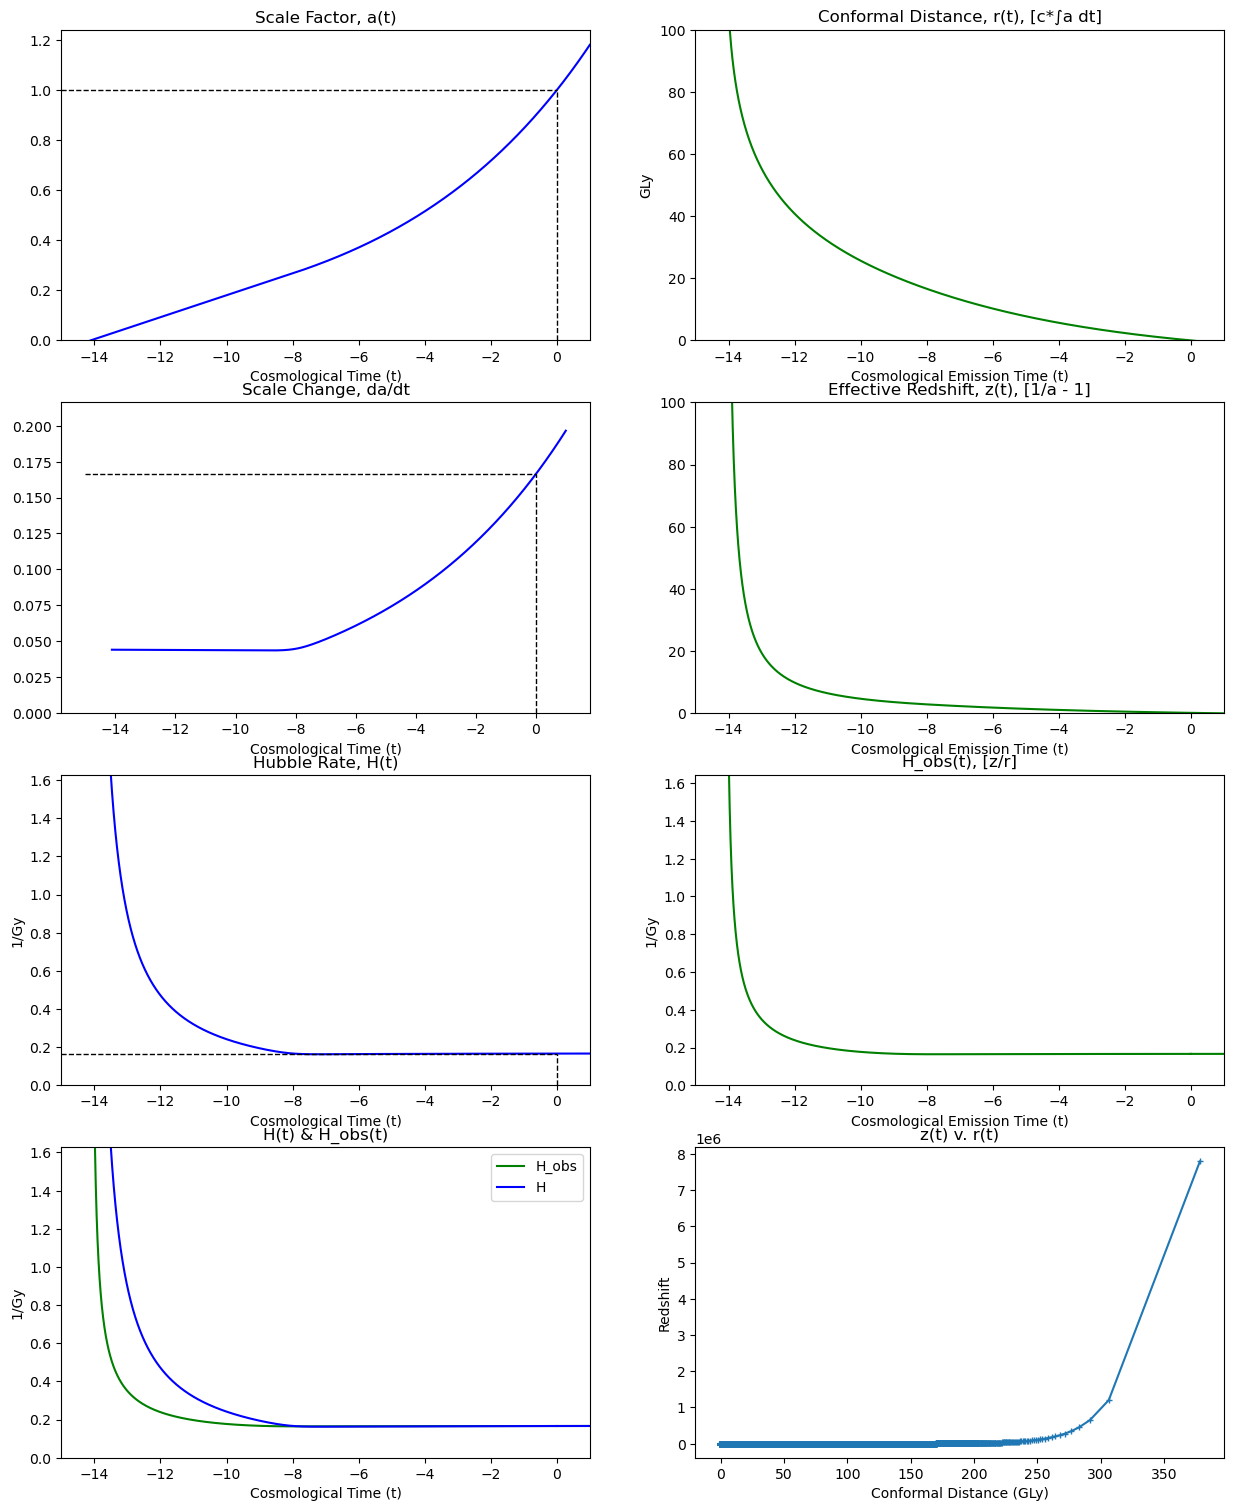

In [19]:
logify = False
#tmin = -8 #ts[np.argmax(1/a)]-1.2
#tmax = 1 # 16.2

HtokmMpc = 3.09e10/31556926
Hyscale = 1
plt.close()
width = 15
fig,ax = plt.subplots(4,2,figsize=(width,2*width*2/(1+np.sqrt(5))))
ax[0,0].set_title("Scale Factor, a(t)")
ax[0,0].set_xlabel("Cosmological Time (t)")
ax[0,0].plot(ts,a,color="blue")
ax[0,0].plot([ts[0],0],[1,1],"--",linewidth=1,color="black")
ax[0,0].plot([0,0],[0,1],"--",linewidth=1,color="black")
#ax[0,0].plot(ts,[0]*len(ts),"--",linewidth=2,color="black")
ax[0,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),tmax)
ax[0,0].set_ylim(0,
                 1.05*np.nanmax(a[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) #
if (logify): 
    ax[0,0].set_ylim(np.nanmin(a),1.05*np.nanmax(a))
    ax[0,0].set_yscale("log")

    
ax[1,0].set_title("Scale Change, da/dt")
ax[1,0].set_xlabel("Cosmological Time (t)")
ax[1,0].plot(ts,dadt,color="blue")
ax[1,0].plot([ts[0],0],[dadt[t_0],dadt[t_0]],"--",linewidth=1,color="black")
ax[1,0].plot([0,0],[0,dadt[t_0]],"--",linewidth=1,color="black")
#ax[1,0].set_xlim(tmin,tmax)
if np.nanmin(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[1,0].set_ylim(0, 1.1*np.nanmax(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else:
    ax[1,0].set_ylim(0, min(1.1*np.nanmax(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                        10*np.nanmin(dadt[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))  )
if (logify): 
    if np.nanmin(dadt) == 0.: ax[1,0].set_ylim(np.nanmax(dadt)/100,1.05*np.nanmax(dadt))
    else: ax[1,0].set_ylim(np.nanmin(dadt),1.05*np.nanmax(dadt))
    ax[1,0].set_yscale("log")

    
ax[2,0].set_title("Hubble Rate, H(t)")
ax[2,0].set_xlabel("Cosmological Time (t)")
ax[2,0].set_ylabel("1/Gy")
ax[2,0].plot(ts,H*Hyscale,color="blue")
ax[2,0].plot([ts[0],0],[Hyscale*H[t_0],Hyscale*H[t_0]],"--",linewidth=1,color="black")
ax[2,0].plot([0,0],[0,Hyscale*H[t_0]],"--",linewidth=1,color="black")
ax[2,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[2,0].set_ylim(0,1.1*np.nanmax(Hyscale*H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[2,0].set_ylim(0, min(1.1*np.nanmax(Hyscale*H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*Hyscale*np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) )
#if (logify): ax[2,0].set_yscale("log")

ax[0,1].set_title("Conformal Distance, r(t), [c*∫a dt]")
ax[0,1].set_xlabel("Cosmological Emission Time (t)")
ax[0,1].set_ylabel("GLy")
ax[0,1].plot(ts,r,color="green")

#ax[0,1].set_xlim(-0.1,0.1)
ax[0,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
ax[0,1].set_ylim(0,
                 min(np.nanmax(r[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),100))
if (logify): 
    ax[0,1].set_ylim(np.nanmin(abs(r)),np.nanmax(r))
    ax[0,1].set_yscale("log")
#ax[0,1].set_ylim(0,2)

ax[1,1].set_title("Effective Redshift, z(t), [1/a - 1]")
ax[1,1].set_xlabel("Cosmological Emission Time (t)")
ax[1,1].plot(ts,z,color="green")
#ax[1,1].set_xlim(-0.1,0.1)
ax[1,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
ax[1,1].set_ylim(0,
                 min(1.05*np.nanmax(z[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),100))
#ax[1,1].set_ylim(-0.1,1.1)
if (logify): 
    if z[t_0-1] == 0.: ax[1,1].set_ylim(np.nanmax(z)/100,1.05*np.nanmax(z))
    else: ax[1,1].set_ylim(z[t_0-1],1.05*np.nanmax(z))
    ax[1,1].set_yscale("log")
#ax[1,1].set_ylim(-0.1,0.1)

ax[2,1].set_title("H_obs(t), [z/r]")
ax[2,1].set_xlabel("Cosmological Emission Time (t)")
ax[2,1].set_ylabel("1/Gy")
ax[2,1].plot(ts,Hobs*Hyscale,color="green")
#if (logify): ax[2,1].set_yscale("log")
#ax[2,1].set_xlim(-0.1,0.1)
ax[2,1].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[2,1].set_ylim(0,1.1*np.nanmax(Hyscale*Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[2,1].set_ylim(0, min(1.1*np.nanmax(Hyscale*Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*Hyscale*np.nanmin(abs(Hobs[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])))  )

ax[3,0].set_title("H(t) & H_obs(t)")
ax[3,0].set_xlabel("Cosmological Time (t)")
ax[3,0].set_ylabel("1/Gy")
ax[3,0].plot(ts,Hobs*Hyscale,label="H_obs",color="green")
ax[3,0].plot(ts,H*Hyscale,label="H",color="blue")
#if (logify): ax[3,0].set_yscale("log")
ax[3,0].legend()
ax[3,0].set_xlim(max(ts[np.nanargmax(1/a[0:t_0])]-1,tmin),1)
if np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]) == 0.:
    ax[3,0].set_ylim(0,1.1*np.nanmax(Hyscale*H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]))
else: 
    ax[3,0].set_ylim(0, min(1.1*np.nanmax(Hyscale*H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))]),
                            10*Hyscale*np.nanmin(H[np.argmin(abs(ts-tmin)):np.argmin(abs(ts-tmax))])) )
#ax[3,0].set_ylim(60,100)

ax[3,1].set_title("z(t) v. r(t)")
ax[3,1].set_xlabel("Conformal Distance (GLy)")
ax[3,1].set_ylabel("Redshift")
ax[3,1].plot(r,z,markersize=5,marker="+")
#ax[3,1].set_xscale("log")
#ax[3,1].set_yscale("log")
#ax[3,1].set_xlim(0,r[np.nanargmin(abs(z-1100))])
#ax[3,1].set_xlim(0,np.nanmax(r))
#ax[3,1].set_ylim(0,20)

plt.show()

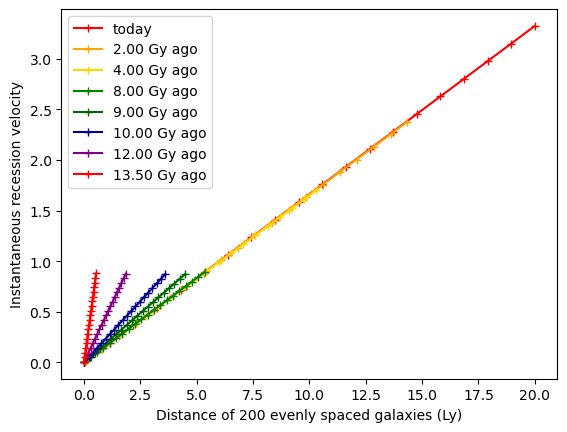

In [21]:
#### Gaia's perspective: Gaia looks into the sky, and needs not wait for photons to arrive; 
   # she instantly knows the conformal distances and relative velocities of each galaxy at any instant of cosmological time

# start with 20 galaxies which happen to be evenly spaced and match Hubble's Law (v ~ H*d) at t=0
# What does Gaia see as their (v vs. d) relationship over cosmological time?

# d(t) = d0 * a(t)
# v(t) = d0 * da/dt
d0 = np.linspace(0.1,20,20)*a[t_0]
v0 = d0*dadt[t_0]

t1 = -2
d1 = d0*a[np.argmin(abs(ts-t1))]
v1 = d0*dadt[np.argmin(abs(ts-t1))]

t2 = -4
d2 = d0*a[np.argmin(abs(ts-t2))]
v2 = d0*dadt[np.argmin(abs(ts-t2))]

t3 = -8
d3 = d0*a[np.argmin(abs(ts-t3))]
v3 = d0*dadt[np.argmin(abs(ts-t3))]

t4 = -9
d4 = d0*a[np.argmin(abs(ts-t4))]
v4 = d0*dadt[np.argmin(abs(ts-t4))]

t5 = -10
d5 = d0*a[np.argmin(abs(ts-t5))]
v5 = d0*dadt[np.argmin(abs(ts-t5))]

t6 = -12
d6 = d0*a[np.argmin(abs(ts-t6))]
v6 = d0*dadt[np.argmin(abs(ts-t6))]

t7 = -13.5
d7 = d0*a[np.argmin(abs(ts-t7))]
v7 = d0*dadt[np.argmin(abs(ts-t7))]
# position at any time is dn_0 * a(t)
# velocity at any time is dn_0 * da/dt(t)

# the graph above shows that for a single galaxy over time, its v/r value will change
# Hubble looked at single time, how v/r changes with initial distance

# this is assuming that you can **INSTANTANEOUSLY*** determine the current velocity and distance
# ANY history a(t) starting with evenly-spaced galaxies will remain evenly spaced
#  geometry analogy: evenly spaced points on the x-axis are always evenly spaced as you "stretch" the x axis as any function of time
#  !!!!!  this can tell you nothing of a(t)  !!!!!

#  .... fortunately, we do not instantly know the recession velocity right now.  We only know the (relative) scale factor at the time of emission
plt.close()
plt.xlabel("Distance of 200 evenly spaced galaxies (Ly)")
plt.ylabel("Instantaneous recession velocity")
plt.plot(d0,v0,label="today",marker="+",color="red")
plt.plot(d1,v1,label=f"{-ts[np.argmin(abs(ts-t1))]:0.2f} Gy ago",marker="+",color="orange")
plt.plot(d2,v2,label=f"{-ts[np.argmin(abs(ts-t2))]:0.2f} Gy ago",marker="+",color="gold")
plt.plot(d3,v3,label=f"{-ts[np.argmin(abs(ts-t3))]:0.2f} Gy ago",marker="+",color="green")
plt.plot(d4,v4,label=f"{-ts[np.argmin(abs(ts-t4))]:0.2f} Gy ago",marker="+",color="darkgreen")
plt.plot(d5,v5,label=f"{-ts[np.argmin(abs(ts-t5))]:0.2f} Gy ago",marker="+",color="darkblue")
plt.plot(d6,v6,label=f"{-ts[np.argmin(abs(ts-t6))]:0.2f} Gy ago",marker="+",color="purple")
plt.plot(d7,v7,label=f"{-ts[np.argmin(abs(ts-t7))]:0.2f} Gy ago",marker="+",color="red")
plt.legend()
plt.show()

In [ ]:
# next step: propose some galaxy distances and emission times so that signals are co-incident now
# evolve the universe forward in time, find the new emission times for the new distances and see if they are still linear in relation
